<a href="https://colab.research.google.com/github/thiago-abarros/twitter-sentiment-analysis/blob/main/notebooks/twitter-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importando Bibliotecas

A seguir, vamos importar as bibliotecas necessárias para o processamento de texto, construção de modelo de Machine Learning e visualização de dados.

In [44]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.src.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
import time
import warnings

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\Thiago
[nltk_data]     Barros\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Thiago
[nltk_data]     Barros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Thiago
[nltk_data]     Barros\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. **Carregamento e Análise Inicial dos Dados**
- **Dataset**: Arquivo CSV contendo tweets categorizados como positivos, negativos, neutros ou irrelevantes.
- **Verificações**:
  - Exibição de amostras do dataset.
  - Checagem e contagem de valores nulos.
  - Estatísticas de distribuição das categorias (`positive`, `neutral`, `negative`, `irrelevant`).

In [80]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('../data/twitter_training.csv')
df_val = pd.read_csv('../data/twitter_validation.csv')
df = pd.concat([df_train, df_val], ignore_index=False)
df.sample(5)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
48534,5932.0,HomeDepot,Negative,"Please don't come home today, harass the peopl...",NaN,NaN,NaN,NaN
68504,3730.0,Cyberpunk2077,Neutral,I am simultaneously being hyped for,NaN,NaN,NaN,NaN
50268,6230.0,FIFA,Negative,FIFA 20 delivers the worst video game I've eve...,NaN,NaN,NaN,NaN
29932,746.0,ApexLegends,Negative,If they make it to where you can’t turn it off...,NaN,NaN,NaN,NaN
18865,12433.0,WorldOfCraft,Neutral,I just deserved [an even more horrific vision ...,NaN,NaN,NaN,NaN


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                                

In [81]:
columns_to_drop = ['2401', '3364', 'Facebook', 'Irrelevant',
                   'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']
df = df.drop(columns_to_drop, axis=1)

df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet', 'Positive': 'Sentiment', 'Borderlands':"Branch"})
df.head()

,Branch,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [10]:
print(df.isnull().sum())

Branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [82]:
df.dropna(inplace=True)
df.isnull().sum()   

Branch       0
Sentiment    0
Tweet        0
dtype: int64

In [83]:
df.duplicated().sum()

np.int64(3038)

In [84]:
remove_duplicates = df.drop_duplicates()
df = remove_duplicates
df.duplicated().sum()

np.int64(0)

## Deduções iniciais
- Negativos (30.39%) são o maior grupo, indicando que o sentimento predominante na base é negativo. Isso pode sugerir que o tema dos tweets é controverso ou que os usuários tendem a compartilhar mais emoções negativas.
- Positivos (27.55%) vêm em segundo lugar, sugerindo um equilíbrio razoável com os negativos, mas ainda menos frequente.
- Neutros (24.52%) estão próximos dos positivos, indicando uma quantidade significativa de tweets que são informativos ou sem uma carga emocional explícita.
- Irrelevantes (17.54%) representam uma parcela menor, indicando que uma porção razoável dos tweets não contribui diretamente para a análise de sentimentos.

In [85]:
# Filtrando os tweets por sentimento
tweets_positivos = df.loc[df['Sentiment'] == 'Positive']
tweets_neutros = df.loc[df['Sentiment'] == 'Neutral']
tweets_negativos = df.loc[df['Sentiment'] == 'Negative']
tweets_irrelevantes = df.loc[df['Sentiment'] == 'Irrelevant']

# Calculando o total de tweets na base
total_tweets = df.shape[0]

# Calculando e exibindo os números e porcentagens
print(f"Número de tweets positivos: {tweets_positivos.shape[0]} ({(tweets_positivos.shape[0] / total_tweets) * 100:.2f}%)")
print(f"Número de tweets neutros: {tweets_neutros.shape[0]} ({(tweets_neutros.shape[0] / total_tweets) * 100:.2f}%)")
print(f"Número de tweets negativos: {tweets_negativos.shape[0]} ({(tweets_negativos.shape[0] / total_tweets) * 100:.2f}%)")
print(f"Número de tweets irrelevantes: {tweets_irrelevantes.shape[0]} ({(tweets_irrelevantes.shape[0] / total_tweets) * 100:.2f}%)")

Número de tweets positivos: 19548 (27.55%)
Número de tweets neutros: 17398 (24.52%)
Número de tweets negativos: 21565 (30.39%)
Número de tweets irrelevantes: 12446 (17.54%)


## 3. **Visualizações Exploratórias**
- **Gráfico de Pizza**: Representação percentual das categorias de tweets.
- **Nuvens de Palavras**:
  - Geradas para todas as categorias combinadas, assim como separadamente para tweets positivos, negativos e neutros.
  - Função personalizada para criação e salvamento das nuvens.

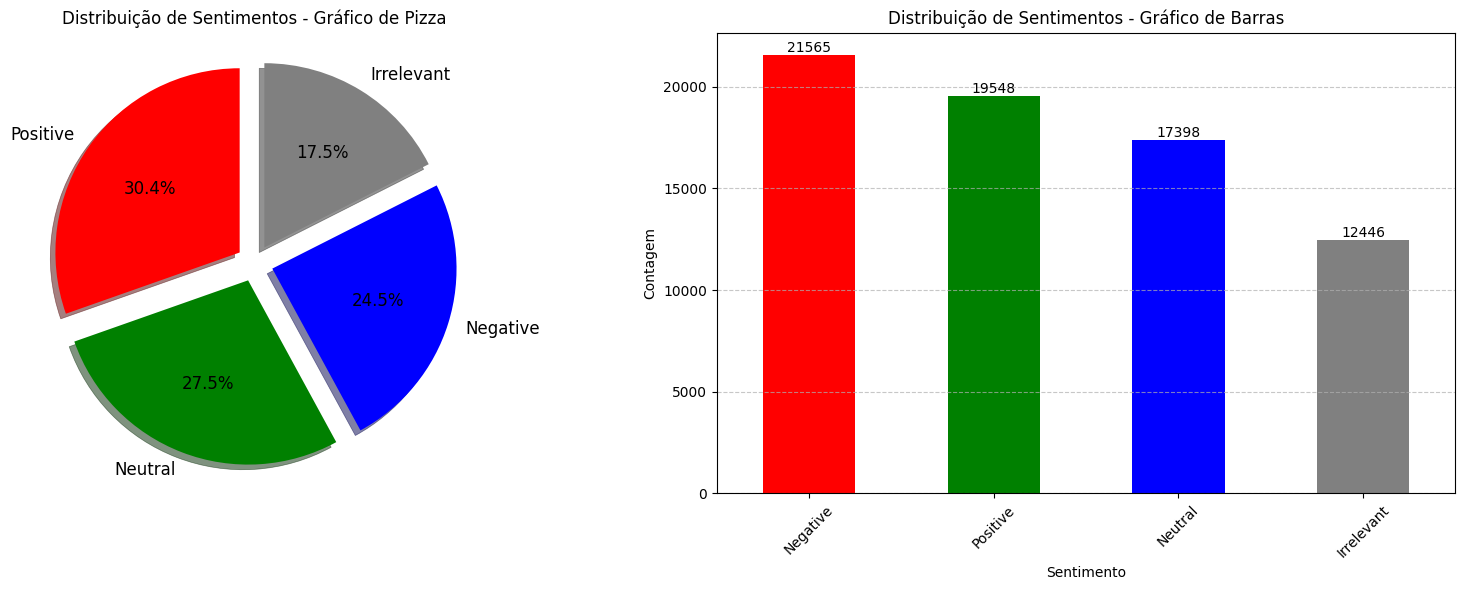

In [16]:
# Define cores personalizadas
cores = ['red', 'green', 'blue', 'gray']

# Cria subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotando o gráfico de pizza para a distribuição dos sentimentos com cores personalizadas
axs[0].pie(df['Sentiment'].value_counts(), labels=df['Sentiment'].unique(), autopct='%1.1f%%',
           startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
           explode=[0.1, 0.1, 0.1, 0.1], colors=cores, shadow=True)
axs[0].set_title('Distribuição de Sentimentos - Gráfico de Pizza')

# Plotando o gráfico de barras para a distribuição dos sentimentos
axs[1] = df['Sentiment'].value_counts().plot(kind='bar', color=cores, ax=axs[1])
axs[1].set_title('Distribuição de Sentimentos - Gráfico de Barras')
axs[1].set_xlabel('Sentimento')
axs[1].set_ylabel('Contagem')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona texto no topo de cada barra no gráfico de barras
for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

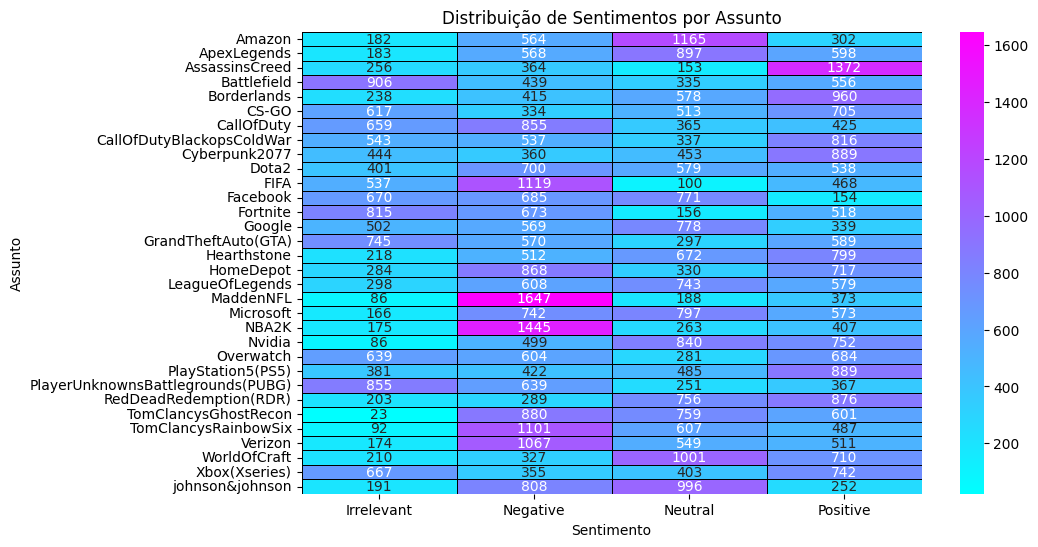

In [24]:
# Configura o tamanho da figura
plt.figure(figsize=(10, 6))

# Cria uma tabela de contagem cruzada entre Assunto (Branch) e Sentimento
tabela_contagem = pd.crosstab(index=df['Branch'], columns=df['Sentiment'])

# Plota o mapa de calor (heatmap) para a distribuição de sentimentos por Assunto
sns.heatmap(tabela_contagem, cmap='cool', annot=True, fmt='d', linewidths=0.5, linecolor='black')

# Configura o título e os rótulos dos eixos
plt.title('Distribuição de Sentimentos por Assunto')
plt.xlabel('Sentimento')
plt.ylabel('Assunto')

# Exibe o gráfico
plt.show()

In [25]:
# Exibe os valores mínimos e máximos de cada sentimento para cada filial
for sentimento in tabela_contagem.columns:
    filial_min = tabela_contagem[sentimento].idxmin()
    filial_max = tabela_contagem[sentimento].idxmax()
    valor_min = tabela_contagem[sentimento].min()
    valor_max = tabela_contagem[sentimento].max()
    print(f"Sentimento '{sentimento}':")
    print(f"  Valor mínimo '{valor_min}' na Filial '{filial_min}'")
    print(f"  Valor máximo '{valor_max}' na Filial '{filial_max}'\n")

Sentimento 'Irrelevant':
  Valor mínimo '23' na Filial 'TomClancysGhostRecon'
  Valor máximo '906' na Filial 'Battlefield'

Sentimento 'Negative':
  Valor mínimo '289' na Filial 'RedDeadRedemption(RDR)'
  Valor máximo '1647' na Filial 'MaddenNFL'

Sentimento 'Neutral':
  Valor mínimo '100' na Filial 'FIFA'
  Valor máximo '1165' na Filial 'Amazon'

Sentimento 'Positive':
  Valor mínimo '154' na Filial 'Facebook'
  Valor máximo '1372' na Filial 'AssassinsCreed'



In [17]:
def create_wordcloud(text, path):
    """
    Gera e salva uma nuvem de palavras (Word Cloud) a partir de um texto fornecido.

    Parâmetros:
    -----------
    text : str
        O texto de entrada para gerar a nuvem de palavras. As palavras mais frequentes no texto serão destacadas.

    path : str
        O caminho do arquivo onde a imagem da nuvem de palavras será salva.

    Funcionamento:
    --------------
    1. Define uma lista de palavras de parada (`stopwords`) utilizando o conjunto `STOPWORDS` da biblioteca WordCloud.
       Essas palavras comuns (como "o", "e", "de") serão excluídas da nuvem.

    2. Configura a nuvem de palavras com as seguintes propriedades:
       - `background_color="white"`: Define o fundo da nuvem de palavras como branco.
       - `max_words=3000`: Limita a nuvem a um máximo de 3000 palavras.
       - `stopwords=stopwords`: Exclui as palavras de parada definidas anteriormente.
       - `random_state=42`: Define um valor fixo para o gerador de números aleatórios, garantindo que o layout da nuvem de palavras seja reproduzível.
       - `width=900` e `height=500`: Define as dimensões da imagem da nuvem de palavras.
       - `repeat=True`: Permite que palavras se repitam na imagem, se necessário.

    3. Converte o texto de entrada para string e gera a nuvem de palavras com base nesse texto.

    4. Salva a imagem gerada no caminho especificado (`path`) usando o método `to_file()`.

    5. Exibe uma mensagem de sucesso após salvar a imagem.

    6. Carrega e exibe a imagem da nuvem de palavras usando a função `display()` e o módulo `Image` da biblioteca `PIL`.

    Retorna:
    --------
    Não há retorno explícito, mas a imagem da nuvem de palavras será exibida e salva no local especificado.

    Exemplo de uso:
    ---------------
    create_wordcloud("Aqui vai o seu texto", "nuvem_palavras.png")
    """
    stopwords = set(STOPWORDS)
    wc = WordCloud(
        background_color="white",
        max_words=3000,
        stopwords=stopwords,
        random_state=42,
        width=900,
        height=500,
        repeat=True,
    )
    wc.generate(str(text))
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    path = path
    display(Image.open(path))

## Nuvem de Palavras para todos os tweets

Word Cloud Saved Successfully


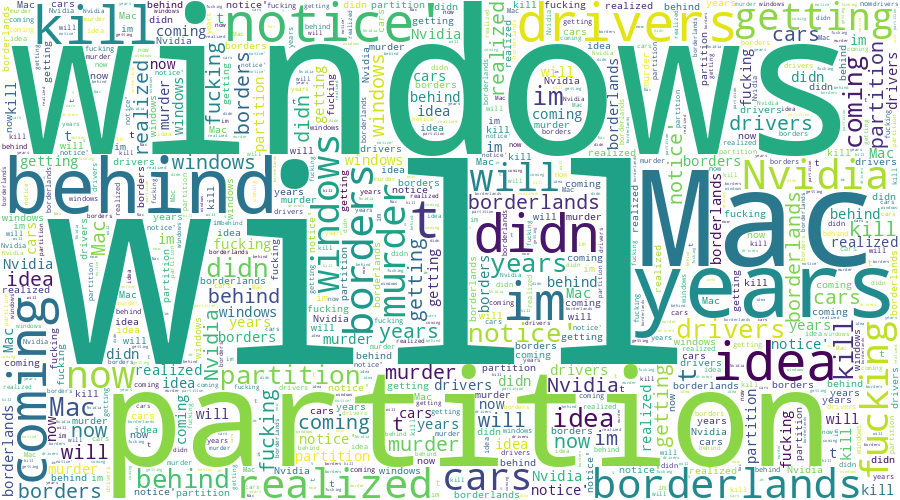

<Figure size 1200x640 with 0 Axes>

In [42]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(df["Tweet"].values, "resources/all.png")

## Nuvem de Palavras dos Tweets Positivos

Word Cloud Saved Successfully


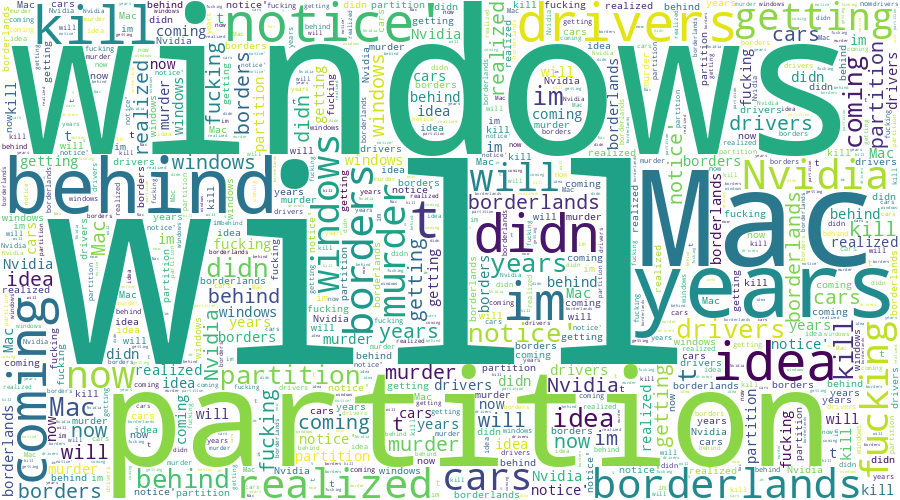

<Figure size 1200x640 with 0 Axes>

In [43]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweets_positivos["Tweet"].values, "resources/positive.png")

## Nuvem de Palavras dos Tweets Negativos

Word Cloud Saved Successfully


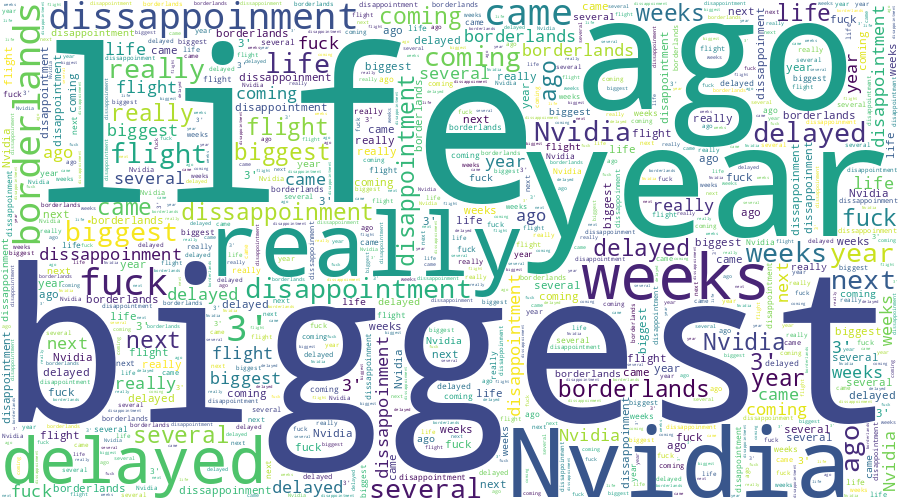

<Figure size 1200x640 with 0 Axes>

In [38]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweets_negativos["Tweet"].values, "resources/negative.png")

## Nuvem de Palavras dos Tweets Neutros

Word Cloud Saved Successfully


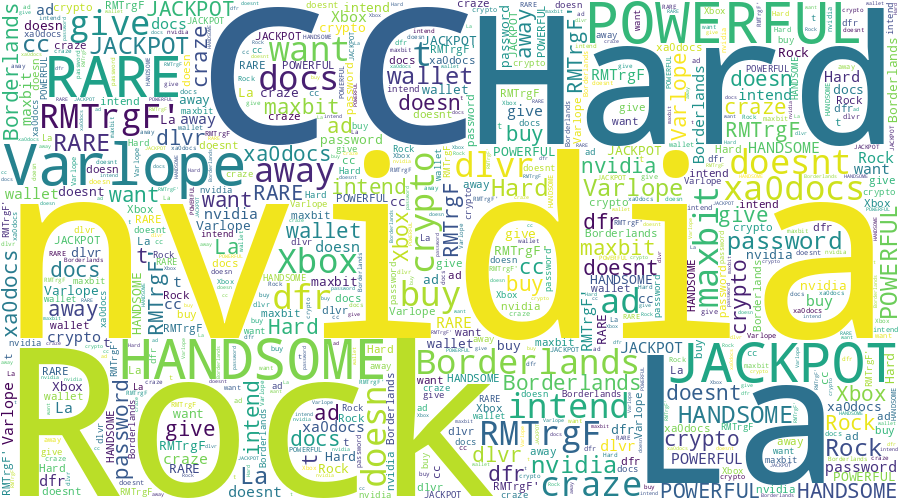

<Figure size 1200x640 with 0 Axes>

In [40]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweets_neutros["Tweet"].values, "resources/neutral.png")

## Nuvem de Palavras dos Tweets Irrelevantes

In [ ]:
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweets_irrelevantes["Tweet"].values, "resources/irrelevant.png")

# 3. **Pré-processamento dos Dados**
- **Stemming**: Redução das palavras às suas raízes utilizando o algoritmo Porter Stemmer.
- **Tokenização do texto**: Esse passo envolve separar o texto em palavras ou tokens individuais. Esses tokens servem como unidades básicas para análises futuras.
- **Remoção de Stopwords**: Excluindo palavras irrelevantes para análise de sentimentos.
- **Remoção de Emojis**: Emojis são representações gráficas que podem não contribuir muito para a tarefa de classificação, logo, podem ser removidas.

In [86]:
def filtrar_nao_strings(df, coluna):
    """
    Filtrar linhas que contenham valores não textuais (não-strings) na coluna especificada.
    Converte valores não textuais em strings.
    """
    df = df.dropna(subset=[coluna])  # Remove valores nulos na coluna
    df[coluna] = df[coluna].astype(str)  # Converte os valores da coluna para strings
    return df

def normalizar_texto(texto):
    """Converte o texto para letras minúsculas para garantir consistência no corpus."""
    return texto.lower()

def remover_tags_html(texto):
    """Remove tags HTML do texto."""
    return re.sub(r'<.*?>', '', texto)  # Substitui qualquer padrão de tag HTML por uma string vazia

def remover_urls(texto):
    """Remove URLs ou hyperlinks do texto."""
    return re.sub(r'http\S+|www\S+', '', texto)  # Substitui padrões de URLs por uma string vazia

def remover_numeros(texto):
    """Exclui dígitos numéricos do texto."""
    return re.sub(r'\d+', '', texto)  # Substitui todos os dígitos numéricos por uma string vazia

def remover_pontuacao(texto):
    """Remove sinais de pontuação do texto."""
    return texto.translate(str.maketrans('', '', string.punctuation))  # Remove caracteres de pontuação

In [87]:
def tokenizar_texto(texto):
    """Dividir o texto em palavras ou tokens individuais."""
    return word_tokenize(texto)

def remover_stopwords(tokens):
    """Eliminar palavras comuns (stopwords) dos tokens."""
    stop_words = set(stopwords.words('english'))  # Define as stopwords em inglês
    return [palavra for palavra in tokens if palavra not in stop_words]

def remover_emojis(texto):
    """Remover emojis do texto."""
    if isinstance(texto, str):  # Verifica se o texto é uma string
        # Define o padrão para capturar emojis
        emoji_pattern = re.compile("[" 
                                   u"\U0001F600-\U0001F64F"  # Emojis de rostos
                                   u"\U0001F300-\U0001F5FF"  # Emojis de símbolos e objetos
                                   u"\U0001F680-\U0001F6FF"  # Emojis de transporte e mapas
                                   u"\U0001F1E0-\U0001F1FF"  # Bandeiras
                                   u"\U00002500-\U00002BEF"  # Outros símbolos e pictogramas
                                   u"\U00002702-\U000027B0"  # Símbolos adicionais
                                   u"\U000024C2-\U0001F251"  
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"  
                                   u"\u2640-\u2642" 
                                   u"\u2600-\u2B55"
                                   u"\u200d" 
                                   u"\u23cf" 
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f" 
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', texto)  # Substitui os emojis por uma string vazia
    else:
        return texto  # Retorna o texto original se não for uma string

def vetorizar_dados(dados_texto):
    """
    Vetoriza os dados textuais utilizando TF-IDF (Term Frequency - Inverse Document Frequency).
    """
    # Inicializa o TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Ajusta e transforma os dados de texto para gerar os vetores TF-IDF
    tfidf_vectores = tfidf_vectorizer.fit_transform(dados_texto)
    return tfidf_vectores, tfidf_vectorizer

In [88]:
def preprocess_text(df):
    df = filtrar_nao_strings(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalizar_texto)
    df['Tweet'] = df['Tweet'].apply(remover_tags_html)
    df['Tweet'] = df['Tweet'].apply(remover_urls)
    df['Tweet'] = df['Tweet'].apply(remover_numeros)
    df['Tweet'] = df['Tweet'].apply(remover_pontuacao)
    df['Tweet'] = df['Tweet'].apply(tokenizar_texto)
    df['Tweet'] = df['Tweet'].apply(remover_stopwords)
    df['Tweet'] = df['Tweet'].apply(remover_emojis)
    return df

df_processed = preprocess_text(df)

In [89]:
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))
df_processed['Tweet'].head()

0              coming borders kill
1      im getting borderlands kill
2     im coming borderlands murder
3    im getting borderlands murder
4    im getting borderlands murder
Name: Tweet, dtype: object

In [90]:
df_processed.to_csv("../data/clean_data.csv", index=False)

## **Divisão de Dados**
- Separação dos dados em conjuntos de treino (60%), conjunto de testes (20%) e conjunto de validação (20%).

In [112]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(df, test_size=0.2, random_state=42):
    """
    Realiza o pré-processamento dos dados, incluindo divisão em treino, validação e teste, 
    padding das sequências e conversão para o formato adequado.

    :param df: DataFrame contendo as colunas 'Tweet' e 'Sentiment'.
    :param tokenizer: Tokenizer previamente ajustado para os dados.
    :param maxlen: Comprimento máximo das sequências após o padding.
    :param test_size: Proporção dos dados para o conjunto de teste.
    :param val_size: Proporção dos dados para o conjunto de validação (do conjunto de treino).
    :param random_state: Semente para a geração de números aleatórios para reprodutibilidade.
    
    :return: Tupla com os arrays X_train, X_val, X_test, y_train, y_val, y_test e o tamanho do vocabulário.
    """
    X = df['Tweet']
    y = df['Sentiment']

    # Divisão inicial entre treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Convertendo texto em features TF-IDF
    vectorizer = TfidfVectorizer(max_features=30000)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Tamanho de cada um dos arrays
    print(f"Tamanho do X_train: {X_train.shape}")
    print(f"Tamanho do X_test: {X_test.shape}")
    print(f"Tamanho do y_train: {y_train.shape}")
    print(f"Tamanho do y_test: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# 4. **Modelos Utilizados**

## Rede Neural: Classificação Multiclasse
- Arquitetura:
- **Função de Perda**: `categorical_crossentropy`.
- **Métrica**: Acurácia.

In [105]:
def build_neural_net_multiclass(input_length):
    model = Sequential(name="LSTM_Multiclass_Classifier")
    model.add(Embedding(1000, output_dim=100, input_length=input_length))
    model.add(LSTM(100))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(3, activation="softmax"))  # Multiclass classification
    return model

from keras.metrics import Precision, Recall, AUC

def compile_model(model, loss, optimizer="adam"):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
)

## Support Vector

In [115]:
from sklearn.svm import SVC

def train_svc(X_train, y_train):
    print("\nTreinando o modelo de support vector...")
    model = SVC()
    model.fit(X_train, y_train)
    
    return model

## KNN com GridSearch

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def train_knn(X_train, y_train):
    print("\nTreinando o modelo KNN...")
    knn = KNeighborsClassifier()

    # Grid Search para hiperparâmetros
    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring='accuracy', cv=5)

    # Treinamento do modelo
    grid_knn.fit(X_train, y_train)
    print(f"Melhores hiperparâmetros para KNN: {grid_knn.best_params_}")
    print(f"Melhor acurácia para KNN (cross-validation): {grid_knn.best_score_:.4f}")

    return grid_knn.best_estimator_

## Arvore de Decisão com Grid Search

In [117]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train):
    print("\nTreinando o modelo de Árvore de Decisão...")
    dt = DecisionTreeClassifier(random_state=42)
    
    # Grid Search para hiperparâmetros
    param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, scoring='accuracy', cv=5)
    
    # Treinamento do modelo
    grid_dt.fit(X_train, y_train)
    print(f"Melhores hiperparâmetros para Árvore de Decisão: {grid_dt.best_params_}")
    print(f"Melhor acurácia para Árvore de Decisão (cross-validation): {grid_dt.best_score_:.4f}")
    
    return grid_dt.best_estimator_

## XGBoost


In [118]:
import xgboost as xgb

def train_xgboost(X_train, y_train, X_val=None, y_val=None):
    print("\nTreinando o modelo XGBoost...")

    # Pré-processamento dos rótulos
    y_train_corrected = correct_negative_values(y_train)
    y_train_corrected = preprocess_labels(y_train_corrected)

    # Ajuste de peso para classes desbalanceadas
    scale_pos_weight = get_scale_pos_weight(y_train_corrected)

    # Configuração do modelo
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',  # Probabilidades para maior controle
        num_class=3,
        scale_pos_weight=scale_pos_weight
    )

    # Treinamento com avaliação contínua
    model.fit(
        X_train, y_train_corrected
    )

    return model

def correct_negative_values(y):
    if np.any(y < 0):
        y = np.clip(y, 0, None)
    return y

def preprocess_labels(y):
    y = np.array(y)
    if len(y.shape) > 1:  # Convertendo one-hot encoded para índices
        print("Convertendo rótulos de one-hot encoding para inteiros...")
        y = np.argmax(y, axis=1)
    return y

def get_scale_pos_weight(y):
    """Calcula os pesos para classes desbalanceadas."""
    class_counts = np.bincount(y)  # Conta os exemplos por classe
    total_samples = len(y)
    weights = total_samples / (len(class_counts) * class_counts)
    return weights

# 5. **Relatório final dos modelos utilizados**

In [113]:
df = pd.read_csv("../data/clean_data.csv")
df['Tweet'] = df['Tweet'].fillna('')
X_train, X_test, y_train, y_test = preprocess_data(df)

Tamanho do X_train: (56765, 30000)
Tamanho do X_test: (14192, 30000)
Tamanho do y_train: (56765,)
Tamanho do y_test: (14192,)


In [106]:
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Configuração inicial
input_length = 100
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=True)


nn_multiclass_model = build_neural_net_multiclass(input_length)
compile_model(nn_multiclass_model, loss="categorical_crossentropy")
nn_multiclass_model.summary()

Model: "LSTM_Multiclass_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Treinamento do modelo 2
history_2 = nn_multiclass_model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    callbacks=[early_stop],
)

ValueError: Invalid dtype: object

## Salvando os modelos

In [38]:
from tensorflow.keras.models import save_model
import os
import joblib
from datetime import datetime

def save_any_model(model, model_name):
    """
    Salva modelos do Keras ou scikit-learn em um arquivo com timestamp para facilitar a organização.
    :param model: O modelo treinado a ser salvo (Keras ou scikit-learn)
    :param model_name: Nome base do modelo
    """
    # Criar diretório 'models' caso não exista
    os.makedirs("models", exist_ok=True)

    # Gerar nome do arquivo com timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = os.path.join("models", f"{model_name}_{timestamp}")

    if hasattr(model, "save"):  # Verifica se é um modelo Keras
        file_path += ".keras"
        model.save(file_path)
        print(f"Modelo Keras salvo em: {file_path}")
    else:  # Assume que é um modelo scikit-learn ou outro objeto serializável
        file_path += ".joblib"
        joblib.dump(model, file_path)
        print(f"Modelo scikit-learn salvo em: {file_path}")

In [195]:
save_any_model(model_2, model_name="neural_network_multiclass")

Modelo Keras salvo em: models\neural_network_binary_20241216_184017.keras
Modelo Keras salvo em: models\neural_network_multiclass_20241216_184018.keras


In [ ]:
best_knn = train_knn(X_train, y_train)
best_dt = train_decision_tree(X_train, y_train)
xgboost_model = train_xgboost(X_train, y_train)
support_vector_model = train_svc(X_train, y_train)


Treinando o modelo KNN...
Melhores hiperparâmetros para KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Melhor acurácia para KNN (cross-validation): 0.8814

Treinando o modelo de Árvore de Decisão...


In [192]:
support_vector_model = train_svc(X_train, y_train)


Treinando o modelo de support vector...


In [101]:
xgboost_model = train_xgboost(X_train, y_train)


Treinando o modelo XGBoost...
Convertendo rótulos de one-hot encoding para inteiros...


In [194]:
save_any_model(best_knn, "best_knn")
save_any_model(best_dt, "best_dt")
save_any_model(xgboost_model, "xgboost_model")
save_any_model(support_vector_model, "svm_model")

Modelo scikit-learn salvo em: models\best_knn_20241216_183941.joblib
Modelo scikit-learn salvo em: models\best_dt_20241216_183941.joblib
Modelo scikit-learn salvo em: models\xgboost_model_20241216_183941.joblib
Modelo scikit-learn salvo em: models\svm_model_20241216_183941.joblib


## Carregando os Modelos Salvos

In [197]:
from tensorflow.keras.models import load_model

nn_binary_model = load_model("models/neural_network_binary.keras")
nn_multiclass_model = load_model("models/neural_network_multiclass.keras")

# Recompilando os modelos
nn_binary_model.compile(optimizer='adam', 
                        loss='binary_crossentropy', 
                        metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

nn_multiclass_model.compile(optimizer='adam', 
                            loss='categorical_crossentropy', 
                            metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

decision_tree_model = joblib.load("models/best_dt.joblib")
knn_model = joblib.load("models/best_knn.joblib")
xgboost_model = joblib.load("models/xgboost_model.joblib")
svm_model = joblib.load("models/svm_model.joblib")

## Avaliação dos modelos desenvolvidos

In [156]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_from_matrix(conf_matrix, class_names, title="Matriz de Confusão", figsize=(8, 6), cmap="Blues"):
    """
    Plota a matriz de confusão diretamente de uma matriz fornecida.

    Args:
        conf_matrix (array): Matriz de confusão calculada.
        class_names (list): Nomes das classes (para rótulos nos eixos).
        title (str): Título do gráfico.
        figsize (tuple): Tamanho do gráfico.
        cmap (str): Esquema de cores para o heatmap.
    """
    # Configurar o gráfico
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)

    # Adicionar títulos e rótulos
    plt.title(title)
    plt.xlabel("Classes Preditas")
    plt.ylabel("Classes Reais")

    # Exibir o gráfico
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title="Matriz de Confusão", figsize=(8, 6), cmap="Blues"):
    """
    Plota a matriz de confusão com valores anotados.

    Args:
        y_true (list or array): Classes reais.
        y_pred (list or array): Classes preditas pelo modelo.
        class_names (list): Nomes das classes (para rótulos nos eixos).
        title (str): Título do gráfico.
        figsize (tuple): Tamanho do gráfico.
        cmap (str): Esquema de cores para o heatmap.
    """
    
    # Se y_val for multilabel ou one-hot, converte para inteiros
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Verifica se y_val está em one-hot
        y_true = np.argmax(y_true, axis=1)
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)  # Converte de one-hot para rótulos inteiros
    
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:  # Verifica se y_val está em one-hot
        y_pred = np.argmax(y_pred, axis=1)
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)  # Converte de one-hot para rótulos inteiros
    
    # Gerar a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Configurar o gráfico
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)

    # Adicionar títulos e rótulos
    plt.title(title)
    plt.xlabel("Classes Preditas")
    plt.ylabel("Classes Reais")

    # Exibir o gráfico
    plt.show()

In [205]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_neural_models(model, X_val, y_val, model_name):
    if not model.optimizer:
        raise ValueError("O modelo não foi compilado. Use model.compile() antes de avaliar.")
    
    try:
        # Gerar as previsões do modelo
        y_pred = model.predict(X_val, verbose=0)
        
        # Se o modelo for de classificação binária, transformar as saídas para 0 ou 1
        if y_pred.shape[1] == 1:  # Se for binário
            y_pred = (y_pred > 0.5).astype(int)
        else:  # Caso de múltiplas classes, escolher a classe com maior probabilidade
            y_pred = y_pred.argmax(axis=1)
        
        # Avaliar o modelo
        results = model.evaluate(X_val, y_val, verbose=0)
    except ValueError as e:
        raise ValueError("Certifique-se de que o modelo foi treinado antes de avaliar.") from e
    
    # Capturar todas as métricas configuradas no modelo
    metrics = dict(zip(model.metrics_names, results))
    print(f"\nAvaliação do {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Se a lista de nomes de classes for fornecida, plote a matriz de confusão
    class_names = ["Classe 0", "Classe 1", "Classe 2"]
    plot_confusion_matrix(y_val, y_pred, class_names)
    
    return metrics

def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    # Se as previsões são one-hot ou probabilidades, converte para inteiros (rótulos)
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Converte de one-hot para rótulos inteiros


    # Se y_val for multilabel ou one-hot, converte para inteiros
    if len(y_val.shape) > 1 and y_val.shape[1] > 1:  # Verifica se y_val está em one-hot
        y_val = np.argmax(y_val, axis=1)
        if len(y_val.shape) > 1 and y_val.shape[1] > 1:
            y_val = np.argmax(y_val, axis=1)  # Converte de one-hot para rótulos inteiros

    print(f"y_pred: {y_pred}")
    print(f"y_val: {y_val}")
    print(f"\nAvaliação do {model_name}:")
    
    # Métricas detalhadas
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="weighted")
    rec = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")

    # Relatórios
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Matriz de confusão
    print("\nMatriz de Confusão:")
    conf_matrix = confusion_matrix(y_val, y_pred)
    class_names = ["Classe 0", "Classe 1", "Classe 2"]
    plot_confusion_matrix_from_matrix(conf_matrix, class_names)

In [198]:
X_train, X_val, X_test, y_train, y_val, y_test, vocab_size = preprocess_data(df, tokenizer)

Tamanho do treino: (97783, 100), (97783, 1)
Tamanho do teste: (32595, 100), (32595, 1)
Tamanho da validação: (32595, 100), (32595, 1)



Avaliação do Bidirectional LSTM Binary Classifier:
loss: -638444.3125
compile_metrics: 0.6303
y_true: [[ 0.]
 [ 1.]
 [ 1.]
 ...
 [ 1.]
 [-1.]
 [ 1.]]
y_pred: [[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


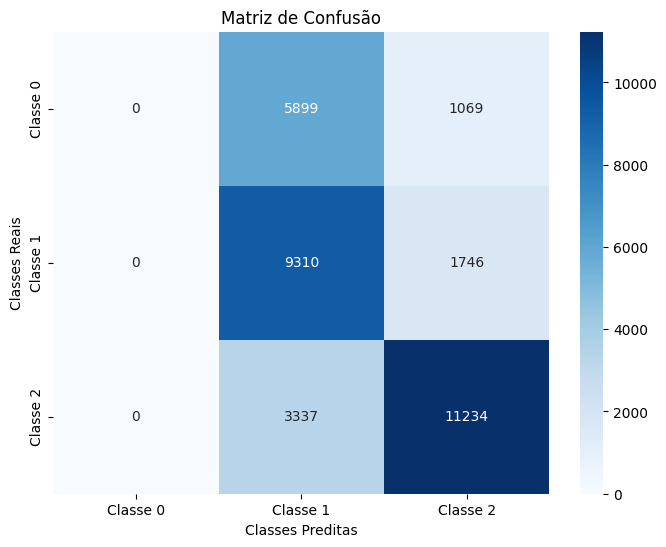

In [199]:
nn_binary_model_metrics = evaluate_neural_models(nn_binary_model, X_val, y_val, "Bidirectional LSTM Binary Classifier")

In [200]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)


Avaliação do LSTM Multiclass Classifier:
loss: 0.7303
compile_metrics: 0.8294
y_true: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
y_pred: [0 1 1 ... 1 2 1]


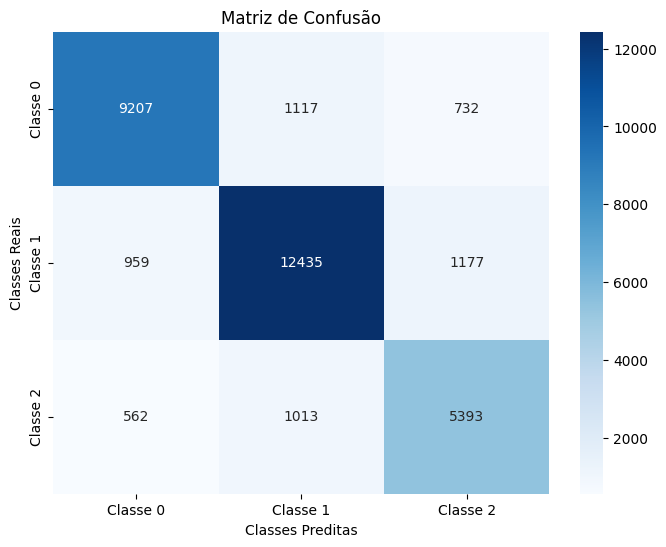

In [201]:
nn_multiclass_model_metrics = evaluate_neural_models(nn_multiclass_model, X_val, y_val, "LSTM Multiclass Classifier")

y_pred: [0 1 1 ... 1 2 1]
y_val: [0 1 1 ... 1 2 1]

Avaliação do Decision Tree Model:
Accuracy: 0.4543
Precision: 0.4575
Recall: 0.4543
F1-Score: 0.4558

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49     11056
           1       0.52      0.50      0.51     14571
           2       0.27      0.29      0.28      6968

    accuracy                           0.45     32595
   macro avg       0.43      0.43      0.43     32595
weighted avg       0.46      0.45      0.46     32595


Matriz de Confusão:


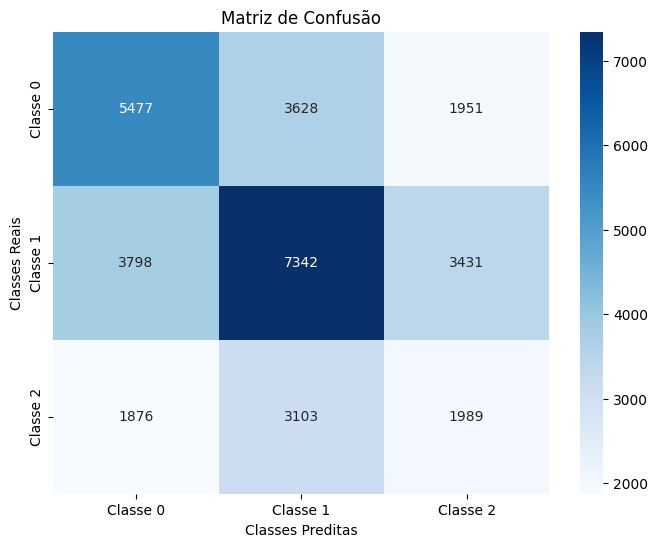

In [206]:
decision_tree_model_metrics = evaluate_model(decision_tree_model, X_val, y_val, "Decision Tree Model")

y_pred: [0 0 1 ... 0 0 2]
y_val: [0 1 1 ... 1 2 1]

Avaliação do KNN Model:
Accuracy: 0.4496
Precision: 0.4409
Recall: 0.4496
F1-Score: 0.4334

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51     11056
           1       0.51      0.45      0.48     14571
           2       0.30      0.16      0.21      6968

    accuracy                           0.45     32595
   macro avg       0.42      0.41      0.40     32595
weighted avg       0.44      0.45      0.43     32595


Matriz de Confusão:


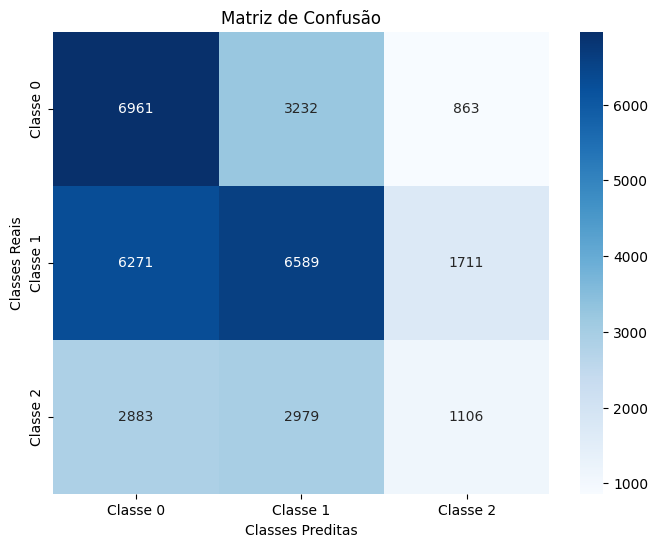

In [207]:
knn_model_metrics = evaluate_model(knn_model, X_val, y_val, "KNN Model")

Convertendo rótulos de one-hot encoding para inteiros...
y_pred: [0 1 1 ... 0 1 1]
y_val: [0 1 1 ... 1 2 1]

Avaliação do XGBoost Model:
Accuracy: 0.5617
Precision: 0.5305
Recall: 0.5617
F1-Score: 0.4955

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.60     11056
           1       0.55      0.78      0.64     14571
           2       0.40      0.01      0.01      6968

    accuracy                           0.56     32595
   macro avg       0.51      0.47      0.42     32595
weighted avg       0.53      0.56      0.50     32595


Matriz de Confusão:


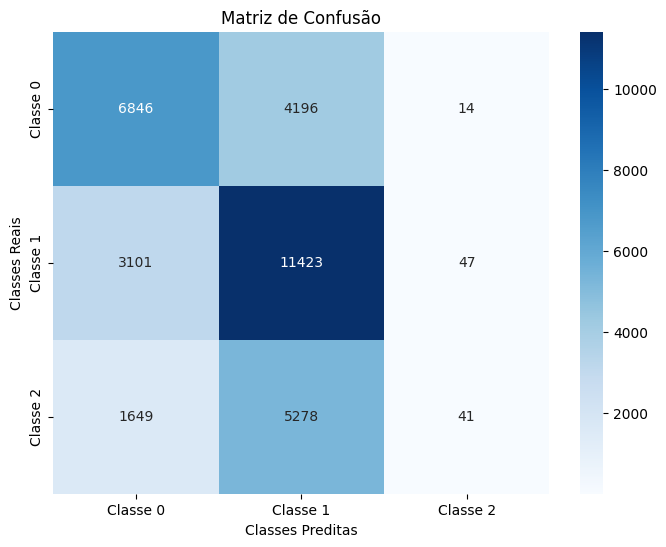

In [208]:
xgboost_model_metrics = evaluate_model(xgboost_model, X_val, preprocess_labels(correct_negative_values(y_val)), "XGBoost Model")

y_pred: [0. 1. 1. ... 0. 0. 1.]
y_val: [0 1 1 ... 1 2 1]

Avaliação do SVM Model:
Accuracy: 0.4870
Precision: 0.3872
Recall: 0.4870
F1-Score: 0.4295

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.46      0.68      0.55     11056
         1.0       0.51      0.57      0.54     14571
         2.0       0.00      0.00      0.00      6968

    accuracy                           0.49     32595
   macro avg       0.24      0.31      0.27     32595
weighted avg       0.39      0.49      0.43     32595


Matriz de Confusão:


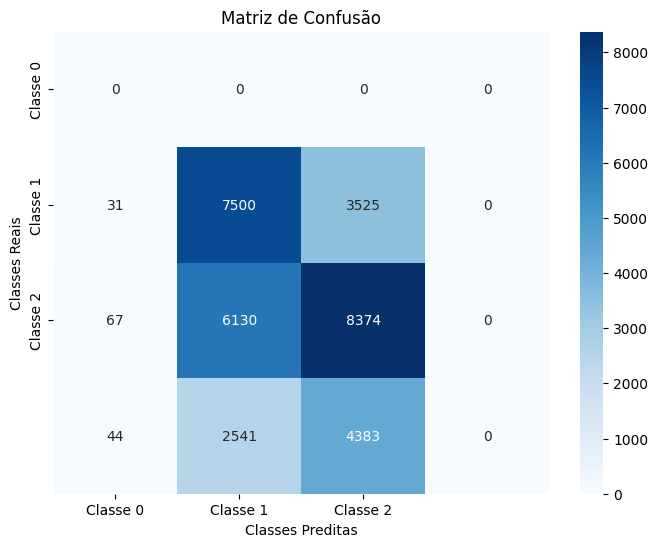

In [209]:
svm_model_metrics = evaluate_model(svm_model, X_val, y_val, "SVM Model")

## 11. **Funções para Predição**
- **Decodificação de Sentimento**:
  - Mapeamento de probabilidades para categorias (`positive`, `neutral`, `negative`).
- **Predição em Tempo Real**:
  - Função personalizada para processar e prever sentimentos de textos novos.

In [164]:
# Escolhendo modelo final
model = nn_multiclass_model

In [165]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SEQUENCE_LENGTH = 300


def decode_sentiment(score):
    """
    Função que recebe uma pontuação de sentimento (score) e retorna o sentimento
    correspondente e a confiança (probabilidade) dessa previsão.

    A função utiliza o índice da maior pontuação no vetor `score` para determinar
    o sentimento e retorna também a probabilidade dessa previsão.

    Parâmetros:
    - score: Vetor contendo as pontuações para cada sentimento (neutro, positivo, negativo).
             Cada valor representa a probabilidade do sentimento correspondente:
             0 -> Neutro, 1 -> Positivo, 2 -> Negativo.

    Retorno:
    - sentimento: O sentimento identificado (NEUTRAL, POSITIVE ou NEGATIVE).
    - confiança: O valor da maior probabilidade (a confiança do modelo na previsão).
    """
    sentimentos = {
        0: NEUTRAL,
        1: POSITIVE,
        2: NEGATIVE,
    }

    # Retorna o sentimento correspondente ao índice da maior pontuação e a confiança
    return sentimentos.get(np.argmax(score)), np.max(score)

In [166]:
def predict(clean_text):
    start_at = time.time()

    # Tokenizando o texto limpo
    x_test = pad_sequences(
        tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH
    )

    # Fazendo as predições
    score = model.predict([x_test])[0]
    print(f"Probabilidade de ser neutro: {score[0]}")
    print(f"Probabilidade de ser positivo: {score[1]}")
    print(f"Probabilidade de ser negativo: {score[2]}")

    # Decodificando o sentimento
    label, max_score = decode_sentiment(score)

    return {
        "label": label,
        "score": float(max_score),
        "elapsed_time": time.time() - start_at,
    }

In [170]:
predict("I love the music")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Probabilidade de ser neutro: 0.0072695487178862095
Probabilidade de ser positivo: 0.28156334161758423
Probabilidade de ser negativo: 0.7111671566963196


{'label': 'NEGATIVE',
 'score': 0.7111671566963196,
 'elapsed_time': 0.13853001594543457}

In [168]:
predict("I have nothing to lose")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Probabilidade de ser neutro: 0.9252973794937134
Probabilidade de ser positivo: 0.0013859269674867392
Probabilidade de ser negativo: 0.07331670820713043


{'label': 'NEUTRAL',
 'score': 0.9252973794937134,
 'elapsed_time': 0.1668717861175537}

In [169]:
predict("Experience has been bad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Probabilidade de ser neutro: 0.000277620303677395
Probabilidade de ser positivo: 0.0021089036017656326
Probabilidade de ser negativo: 0.9976135492324829


{'label': 'NEGATIVE',
 'score': 0.9976135492324829,
 'elapsed_time': 0.10822749137878418}